In [1]:
# sys, file and nav packages:
# import os
import datetime as dt
# import csv
# import json...

# math packages:
import pandas as pd
import numpy as np
import math

# charting:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# home brew utitilties
import utilities.utility_functions as ut
import utilities.abundance_classes as ac
import utilities.chart_kwargs as ck
pd.set_option('display.max_rows', 50)

# set some parameters:
today = dt.datetime.now().date().strftime("%Y-%m-%d")
start_date = '2020-04-01'
end_date = today

# the city, lake and river bassin we are aggregating to
# the keys are column names in the survey data
levels = {"city":"Biel/Bienne","water_name_slug":'bielersee', "river_bassin":'aare'}

# variables for the directory tree
most_recent, survey_data, location_data, code_defs, stat_ent, geo_data, output = ut.make_local_paths()

# name of the output folder:
name_of_project = 'pop_inf_examp'

# add the folder to the directory tree:
project_directory = ut.make_project_folder(output, name_of_project)

# keep track of output
files_generated = []
figure_num = 0
data_num = 0

def add_output(**kwargs):
    files_generated.append({'tag':kwargs['tag'], 'number':kwargs['figure_num'], 'file':kwargs['file'],'type':kwargs['a_type']})
    if kwargs['a_type'] == 'data':
        kwargs['data'].to_csv(F"{kwargs['file']}.csv", index=False)
    else:
        plt.savefig(F"{kwargs['file']}.jpeg", dpi=300)

## <span style="color:#008891">Population and infrastructure</span>

#### <span style="color:#008891">Does population and insfrasturcutre have a meausrable effect on the key indicators</span>

The key indicators are common relationships used to provide insight to the most frequent questions using parameters that are taken directly from the survey data. The key indicators are relatively easy to calculate and interpret. In this section we explore the relationship between population and infrastructure and the key indicators for survey results.

### <span style="color:#008891">Indicators for the most frequent questions</span>

1. What do you find?
2. How often do you find it?
3. How much do you find?
4. What else do you find?
5. Where do you find the most?

These are important questions to answer. The survey results are a census of objects that were primarily washed up on the beach. This helps answer the question:

> **What are we likely to find at the beach?**


> **What are we likely to find in the water?**

The key indicators differ between regions and locations.  Which may mean that the extent and/or nature of the problem is different from one region to another.

The reliability of these indicators is based on the following assumptions:

1. The more trash there is on the ground the more a person is likely to find
2. The survey results represent the minimum amount of trash at that site²
3. For each survey: finding one item does not effect the chance of finding another³


#### <span style="color:#008891">More information </span>

For information on a specific catchment area or a water feature see the notebook for that catchment area (or make one and send a pull request). For more information on the project visit https://www.plagespropres.ch/ .


¹ The EU guide on monitoring marine litter https://mcc.jrc.ec.europa.eu/documents/201702074014.pdfhttps://mcc.jrc.ec.europa.eu/documents/201702074014.pdf<br> ² There is most likely more trash at the survey site, but certainly not less than what was recorded.<br>³ Independent observations : https://stats.stackexchange.com/questions/116355/what-does-independent-observations-meanhttps://stats.stackexchange.com/questions/116355/what-does-independent-observations-mean


#### <span style="color:#008891">A brief reminder of the survey method</span>

A survey is a collection of observations. The observations correspond to the objects that were removed and counted during the survey. Each object is placed into one of 260 categories¹. The location, date, survey dimensions and the total number of objects in each category is noted.

Some locations are sampled monthly, other were only sampled once. 

#### <span style="color:#008891">The scope and size of the data for this example:</span>


In [2]:
# name the data sources and where to find them
# the easiest is to put them in the resources/most_recent directory
# the extension default is resources/most_recent/
data_sources = {    
    "survey_data":"results_with_zeroes.csv",
    "river_bassins":"river_basins.json",
    "beaches":"beaches_with_ranks.csv",
    "codes":"mlw_codes.csv",
    "code_groups":"code_group2.json",    
}

# define the methods to use for the .JSON and .csv files:
my_data_methods = {'json':ut.json_file_get, 'csv':pd.read_csv}

# get your data:
survey_data, river_bassins, dfBeaches, dfCodes, code_groups = ac.get_data_from_most_recent(data_sources, data_methods=my_data_methods)

# format the date to timestamp and slice the data by start/end date
dfSurveys = ac.fo_rmat_and_slice_date(survey_data.copy(), a_format="%Y-%m-%d", start_date=start_date, end_date=end_date)

# add the grouping column defined by river_bassins
data = ac.add_a_grouping_column(dfSurveys, river_bassins, column_to_match="water_name_slug")

# set the index of the beach data to location slug
dfBeaches.set_index('slug', inplace=True)

# set the index of dfCodes to code:
dfCodes.set_index('code', inplace=True)

# make a map to the code descriptions
code_description_map = dfCodes.description

# put the data into a class
# kwargs for the abundance class
a_class_kwargs = dict(
    code_group_data=code_groups,
    levels=['river_bassin', 'water_name_slug', 'city'],
    river_bassins=river_bassins,
    exp_variables=['population','buildings', 'streets', 'intersects', 'pop_group_proj', 'pop_group_rip', 'streets_rank', 'buildings_rank'],       
    code_group_loc=output,    
)

# the data labled by river bassin, water feature, city and beach name with independent variables attached
a = ac.PreprocessData(data,  dfBeaches, these_cols=['loc_date', 'location', 'water_name_slug','date'], **a_class_kwargs)

# define the final data set here:
a_data = a.survey_data.copy()

# identify all records with a quantity > 0
a_data['fail'] = a_data.quantity > 0

# thats it! all the survey records with the independent variables attached and columns to group by
# date, location, (location, date), river bassin, water body, city, material, usage group, or object

# convenience method
def m_ap_code_to_description(data, key, func):
    new_data = data.copy()
    new_data['item'] = new_data.index.map(lambda x: func(x,key ))
    new_data.set_index('item', inplace=True)
    return new_data

# describe the data set:
num_obs = len(a_data)
num_samps = len(a_data.loc_date.unique())
num_obj = a_data.quantity.sum()
num_locs = len(a_data.location.unique())

i_s_na = a_data[a_data.isna().any(axis=1)]


if len(i_s_na) > 0:
    print(F"There are {len(i_s_na)} records with NaN values.\nCheck the column, levels and exp_variable definitions if you have made changes to default\nCheck the availability of Geo data for locations in your selection.")
else:
    print("\nThere are no NaN values, good to go!")
    print(F"\n Results for all surveys between {start_date} and {end_date} from the following catchment areas:\n\n  {a_data.river_bassin.unique()}")
    print(F"\nThere are {'{:,}'.format(num_obs)} observations from {num_samps} surveys.\n\nThere were {'{:,}'.format(num_obj)} objects collected.")


There are no NaN values, good to go!

 Results for all surveys between 2020-04-01 and 2021-04-27 from the following catchment areas:

  ['linth' 'reuss' 'aare' 'rhone' 'ticino']

There are 79,339 observations from 359 surveys.

There were 51,067 objects collected.


In [3]:
# get the daily survye totals by pcs_m and make a map to loc_date:
a_daily_totals = ac.fo_rmat_and_slice_date(a.daily_totals_all, a_format="%Y-%m-%d", start_date=start_date, end_date=end_date)
a_daily_totals.set_index("loc_date", inplace=True)
m_ap_to_survey_totals = a_daily_totals.pcs_m

In [4]:
a_data.columns

Index(['date', 'code', 'pcs_m', 'quantity', 'location', 'loc_date',
       'water_name_slug', 'river_bassin', 'groupname', 'population',
       'buildings', 'streets', 'intersects', 'pop_group_proj', 'pop_group_rip',
       'streets_rank', 'buildings_rank', 'string_date', 'city', 'fail'],
      dtype='object')

In [5]:
a_data.groupname.unique()

array(['food', 'personal items', 'not classified', 'tobacco',
       'construction', 'recreation', 'packaging non food', 'waste water',
       'plastic pieces', 'agriculture', 'less than 5mm'], dtype=object)

In [17]:
a_data['month'] = a_data.loc_date.map(lambda x: int(x[1][5:7]))

use_these_cols = [
    'loc_date','date', 'month', 'location', 'water_name_slug','river_bassin',  'city','population',
    'buildings', 'streets', 'intersects', 'pop_group_proj', 'pop_group_rip',
]

# the values for these object codes will be combined for each survey
method = 'dense'
groupname = ['tobacco']
a_col = '% of total'
a_code = a_data.loc[a_data.groupname.isin(groupname)].copy()
a_code_df = a_code.groupby(use_these_cols, as_index=False).agg({'pcs_m':'sum', 'quantity':'sum'})

# get the fail rate
a_code_df['fail'] = a_code_df.quantity > 0

# map the survey total to each record 
a_code_df['survey_total'] = a_code_df.loc_date.map(lambda x: m_ap_to_survey_totals.loc[[x]][0])
a_code_df['% of total'] = a_code_df.quantity/a_code_df.survey_total

ar_basin = a_code_df[a_code_df.river_bassin == 'aare'].copy()

ar_basin.drop(['pop_group_proj','pop_group_rip'], axis=1, inplace=True)

ar_basin['pop_rank'] =ar_basin.population.rank(method=method)
ar_basin['street_rank']=ar_basin.streets.rank(method=method)
ar_basin['bild_rank'] = ar_basin.buildings.rank(method=method)
ar_basin['int_rank'] = ar_basin.intersects.rank(method=method)

ar_basin['sum_ranks'] = ar_basin.bild_rank + ar_basin.street_rank + ar_basin.pop_rank

<AxesSubplot:xlabel='pop_rank', ylabel='% of total'>

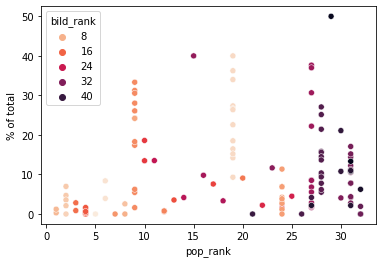

In [18]:
sns.scatterplot(data = ar_basin, x='pop_rank', y=a_col, hue='bild_rank', palette='rocket_r')

<AxesSubplot:xlabel='bild_rank', ylabel='% of total'>

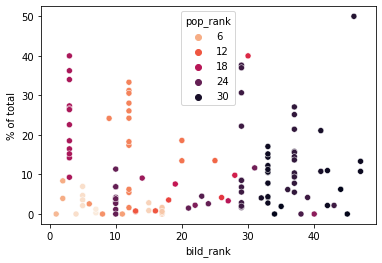

In [19]:
sns.scatterplot(data = ar_basin, x='bild_rank', y=a_col, hue='pop_rank', palette='rocket_r')

<AxesSubplot:xlabel='street_rank', ylabel='% of total'>

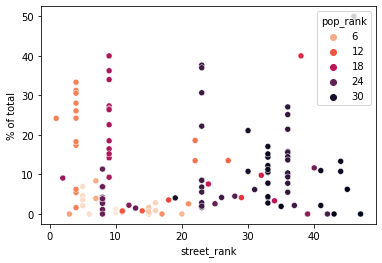

In [20]:
sns.scatterplot(data = ar_basin, x='street_rank', y=a_col,  hue='pop_rank', palette='rocket_r')

<AxesSubplot:xlabel='int_rank', ylabel='% of total'>

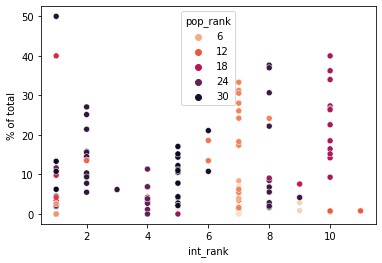

In [21]:
sns.scatterplot(data = ar_basin, x='int_rank', y=a_col, hue='pop_rank', palette='rocket_r')

<AxesSubplot:xlabel='sum_ranks', ylabel='% of total'>

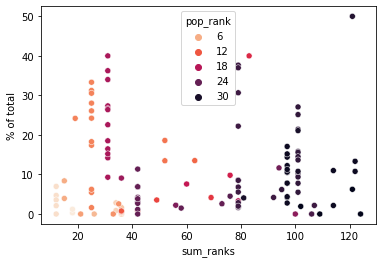

In [22]:
sns.scatterplot(data = ar_basin, x='sum_ranks', y=a_col, hue='pop_rank', palette='rocket_r')

<AxesSubplot:xlabel='month', ylabel='% of total'>

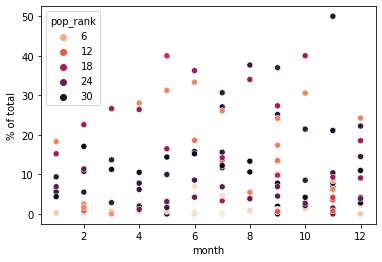

In [23]:
sns.scatterplot(data = ar_basin, x='month', y=a_col, hue='pop_rank', palette='rocket_r')

In [24]:
dfCodes.loc['G119']

material                              Plastic
description     Sheetlike user plastic (>1mm)
source                              Undefined
source_two            Where does it come from
source_three                              NaN
parent_code                       Parent code
direct                                   True
single_use                              False
micro                                   False
ospar_code                                NaN
Name: G119, dtype: object

In [25]:
author = "roger@hammerdirt.ch"
my_message = "Statistics is fun when you do it outside"
print(F"\nProduced by: {author}\nDate: {today}\n\n{my_message}")


Produced by: roger@hammerdirt.ch
Date: 2021-04-27

Statistics is fun when you do it outside


#### <span style="color:#008891">Biel/Bienne: all objects identified</span>

In [26]:
 pd.options.display.max_rows = 999

In [27]:
dfCodes

,material,description,source,source_two,source_three,parent_code,direct,single_use,micro,ospar_code
code,,,,,,,,,,
G212,Chemicals,Oil nodules or coal fragments -- not from a BBQ,Undefined,Where does it come from,none,Parent code,False,False,False,none
G213,Chemicals,Paraffin wax,Undefined,Where does it come from,none,Parent code,True,False,False,181
G214,Chemicals,Oil/tar,Construction,Where does it come from,none,Parent code,False,False,False,111
G135,Cloth,"Clothes, footware, headware, gloves",Clothing,Where does it come from,none,Parent code,True,False,False,54
G136,Cloth,Shoes,Clothing,Where does it come from,none,Parent code,True,False,False,none
G137,Cloth,"Clothing, towels & rags",Clothing,Where does it come from,none,Parent code,True,False,False,54
G138,Cloth,Shoes and sandals,Clothing,Where does it come from,none,Parent code,True,False,False,57
G139,Cloth,Backpacks,Utility items,Recreation,none,Parent code,True,False,False,none
G140,Cloth,"Bags, burlap, hessian, jute or hemp",Packaging,Agriculture,none,Parent code,False,False,False,56
